In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import pywt
%matplotlib inline

In [2]:
face_cascade=cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier("./opencv/haar/haarcascade_eye.xml")

In [3]:
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")

In [4]:
def get_cropped_imgs(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes)>=2:
            return roi_color

In [5]:
cropped_img = get_cropped_imgs("./dataset/maria_sharapova/1368843.jpg")

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


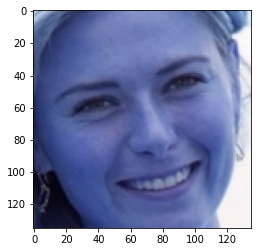

In [ ]:
plt.imshow(cropped_img)

In [6]:
path_to_dataset = "./dataset/"
path_to_cr_data = "./cropped/"

In [7]:
import os
img_dirs = []
for entry in os.scandir(path_to_dataset):
    if entry.is_dir():
        img_dirs.append(entry.path)

FileNotFoundError: [WinError 3] The system cannot find the path specified: './dataset/'

In [8]:
img_dirs

[]

In [9]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [15]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_imgs(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1    

lionel_messi
Generating cropped images in folder:  ./cropped/lionel_messi
maria_sharapova
Generating cropped images in folder:  ./cropped/maria_sharapova
roger_federer
Generating cropped images in folder:  ./cropped/roger_federer
serena_williams
Generating cropped images in folder:  ./cropped/serena_williams
virat_kohli
Generating cropped images in folder:  ./cropped/virat_kohli


In [16]:
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

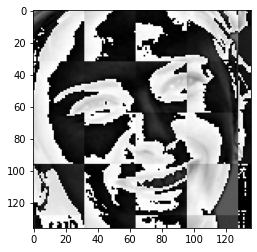

In [17]:
im_har = w2d(cropped_img,'haar',5)
plt.imshow(im_har, cmap='gray')

In [18]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

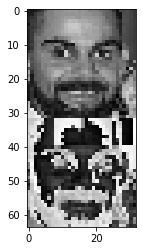

In [50]:
X1, X2, y = [], [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        # print(scalled_raw_img.shape, scalled_img_har.shape)
        combined_img = np.vstack([scalled_raw_img, scalled_img_har])
        plt.imshow(combined_img, cmap='gray')
        X.append(combined_img)
        y.append(class_dict[celebrity_name])  

In [51]:
scalled_img_har

array([[193, 191, 194, ...,  15,   2, 249],
       [193, 197, 224, ...,  11,   4, 249],
       [205, 216, 226, ...,  10,   5, 250],
       ...,
       [ 97, 142, 200, ..., 209,  41, 144],
       [122, 121, 137, ..., 175,  55, 130],
       [126, 129, 141, ...,  75,  41,  51]], dtype=uint8)

In [52]:
X = np.array(X)

In [53]:
y = np.array(y)

In [27]:
X.shape

(187, 4096, 1)

In [22]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [24]:
np.array(X_train).shape

(140, 4096, 1)

In [25]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])

In [26]:
nsamples, nx, ny = X_train.shape
d2_train_dataset = X_train.reshape((nsamples,nx*ny))

In [27]:
pipe.fit(d2_train_dataset, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(C=10))])

In [28]:
nsamples, nx, ny = X_test.shape
d2_test_dataset = X_test.reshape((nsamples,nx*ny))

pipe.score(d2_test_dataset, y_test)

0.8723404255319149

In [29]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [30]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [31]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(d2_train_dataset, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.742857,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.571429,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.714286,{'logisticregression__C': 1}


In [32]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}